In [2]:
from topolearn import *
import numpy as np 
import pandas as pd
import warnings

prob_T=1

# Load the graph
G = EnhancedGraph(n=40, p_edges=0.162, p_triangles=prob_T, seed=0)
B1 = G.get_b1()
B2 = G.get_b2()

# Sub-sampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]
nu = B2.shape[1] # N2
nd = B1.shape[1] # N1
T = int(np.ceil(nu*(1-prob_T)))

# Laplacians
Lu, Ld, L = G.get_laplacians(sub_size=100)
Lu_full = G.get_laplacians(sub_size=100, full=True)
B2_true = B2@G.mask
M =  L.shape[0]


# Problem and Dictionary Dimensionalities
dictionary_type="separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
P = 3 # Number of Kernels (Sub-dictionaries)
J = 2 # Polynomial order
sparsity_mode = "max"
n_search = 3000
n_sim = 10

# Data-Independent Problem Hyperparameters
K0_coll = np.arange(5, 26, 4)
K0_max = K0_coll[-1]
max_iter = 100 
patience = 5 
tol = 1e-3 # tolerance for Patience
lambda_ = 1e-7 # l2 multiplier
verbose = True

In [2]:
gen_params={'dictionary_type':dictionary_type,
        'm_train':m_train,
        'm_test':m_test,
        'P':P,
        'M':M,
        'J':J,
        'K0_max':K0_max,
        'sparsity_mode':sparsity_mode,
        'n_search':n_search,
        'n_sim':n_sim,
        'prob_T':prob_T}

In [3]:
load_data = generate_data(Lu, Ld, **gen_params)

D_true = load_data['D_true']
Y_train = load_data['Y_train']
Y_test = load_data['Y_test']
X_train = load_data['X_train']
X_test = load_data['X_test']
epsilon_true =  load_data['epsilon_true']
c_true = load_data['c_true']

In [5]:
K0_coll[2]

13

In [4]:
warnings.filterwarnings("ignore")
s=2
k0=0
init_params = {"J":J,
            "P":P,
            "c":c_true[s],
            "epsilon":epsilon_true[s],
            "true_prob_T":prob_T,
            "sub_size":100,
            "seed":0,
            "n":40,
            "K0":K0_coll[k0],
            "p_edges":0.162,
            "dictionary_type": "edge"
            }

algo_params = {"lambda_":lambda_,
              "tol":tol,
              "patience":patience,
              "max_iter":max_iter,
              "QP":True,
              "mode":"optimistic",
              "warmup":1,
              "verbose":True
              }

model = TopoSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                **init_params)

model.fit(Lu_true=Lu,
            init_mode="only_X",
            learn_topology=False,
            **algo_params,
            )

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-10


(0.26937905632526843, 0.2690633108153702, 0.0)

Plot saved to c:\Users\engri\Desktop\tesi\TSP-DictionaryLearning\plots\final\random_sparsity25\test_error_edge_T100.png


<Axes: title={'center': 'True dictionary: Edge Laplacian'}, xlabel='Sparsity', ylabel='Test NMSE (log scale)'>

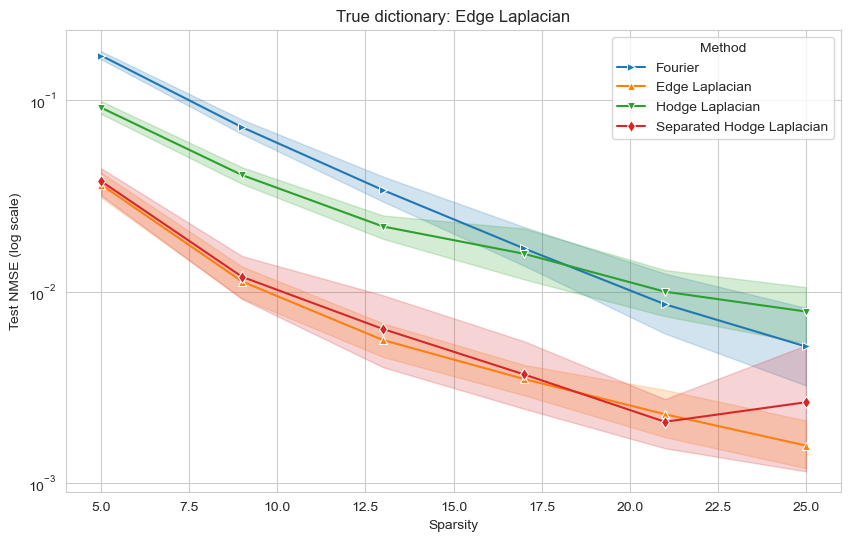

In [5]:
import pickle
from topolearn import *

K0_coll = np.arange(5, 26, 4)

# Plot test error curves
curves_params = {"dictionary_type": "edge",
                 "test_error": True, 
                 "prob_T": 1., 
                 "sparsity_mode":"random", 
                 "sparsity":25}

name = f'max_sparsity{curves_params["sparsity"]}' if curves_params["sparsity_mode"]=="max" else f'random_sparsity{curves_params["sparsity"]}'
with open(f'results\\final\\{name}\\res_{curves_params["dictionary_type"]}_T{int(curves_params["ptob_T"]*100)}.pkl', "rb") as file:
    models = pickle.load(file)
    res = pickle.load(file)

plot_error_curves(dict_errors=res, K0_coll=K0_coll, **curves_params)

In [ ]:
res.keys()

dict_keys(['fourier', 'edge', 'joint', 'separated'])

In [ ]:
hi = h_tmp[np.arange(0, (P * (J + 1)), (J + 1))].reshape((P, 1))
h = h_tmp[
    np.hstack([[i, i + 1] for i in range(1, (P * (J + 1)), (J + 1))])
].reshape((P, J))
np.hstack([h, hi])[:,-1]

array([2.65983443e-10, 2.72128142e-10, 2.41340106e-10])

In [ ]:
warnings.filterwarnings("ignore")

init_params = {"J":J,
            "P":P,
            "c":c_true[s],
            "epsilon":epsilon_true[s],
            "true_prob_T":prob_T,
            "sub_size":100,
            "seed":0,
            "n":40,
            "K0":K0_coll[k0],
            "p_edges":0.162,
            "dictionary_type": dictionary_type
            }

algo_params = {"lambda_":lambda_,
              "tol":tol,
              "patience":patience,
              "max_iter":max_iter,
              "QP":True,
              "mode":"optimistic",
              "warmup":1,
              "verbose":True
              }

no_topo_model = TopoSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                **init_params)

no_topo_model.fit(Lu_true=Lu,
            init_mode="only_X",
            learn_topology=False,
            **algo_params,
            )

(0.1306139156039987, 0.14293616855416788, 19.72308292331602)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
import networkx as nx

def plot_learnt_topology(G_true, Lu_true, B2_true, model_gt, model_opt, model_pess=None, sub_size=100):

    try:
        topos = [model_gt, model_opt, model_pess]
        num_triangles = [
            model_gt.get_numb_triangles(),
            model_opt.get_numb_triangles("optimistic"),
            model_pess.get_numb_triangles("pessimistic")
            ]
        incidence_mat = [B2_true, model_opt.B2, model_pess.B2]
        titles = [
            "True number of triangles: ",
            "Inferred number of triangles (optimistic method): ",
            "Inferred number of triangles (pessimistic method): ",
        ]
        _, axs = plt.subplots(1, 3, figsize=(16, 6))
    except:
        topos = [model_gt, model_opt]
        num_triangles = [
            model_gt.get_numb_triangles(),
            model_opt.get_numb_triangles("optimistic")
            ]
        incidence_mat = [B2_true, model_opt.B2]
        titles = [
            "True number of triangles: ",
            "Inferred number of triangles (optimistic method): "
        ]
        _, axs = plt.subplots(1, 2, figsize=(12, 6))

    i = 0

    for ax, title in zip(axs, titles):
        A = G_true.get_adjacency()
        tmp_G = nx.from_numpy_array(A)
        pos = nx.kamada_kawai_layout(tmp_G)
        nx.draw(tmp_G, pos, with_labels=False, node_color="purple", node_size=15, ax=ax)
        # num_triangles = 0

        for triangle_index in range(B2_true.shape[1]):
            np.random.seed(triangle_index)
            color = np.random.rand(3)
            triangle_vertices = []

            for edge_index, edge in enumerate(tmp_G.edges):
                if edge_index < sub_size:
                    if incidence_mat[i][edge_index, triangle_index] != 0:
                        pos1 = tuple(pos[edge[0]])
                        pos2 = tuple(pos[edge[1]])
                        if pos1 not in triangle_vertices:
                            triangle_vertices.append(pos1)
                        if pos2 not in triangle_vertices:
                            triangle_vertices.append(pos2)
            if triangle_vertices != []:
                # num_triangles += 1
                triangle_patch = Polygon(
                    triangle_vertices,
                    closed=True,
                    facecolor=color,
                    edgecolor="black",
                    alpha=0.3,
                )
                ax.add_patch(triangle_patch)

        ax.set_title(title+str(num_triangles[i]))
        ax.text(
            0.5,
            -0,
            r'$||L_u - \hat{L}_u^*||^2$:' + f' {topos[i].get_topology_approx_error(Lu_true, 4)}         NMSE: {topos[i].get_test_error(4)}',
            ha="center",
            transform=ax.transAxes,
        )

        i += 1

    plt.tight_layout()
    plt.show()

In [ ]:
gt_model.get_test_error(3)

0.074

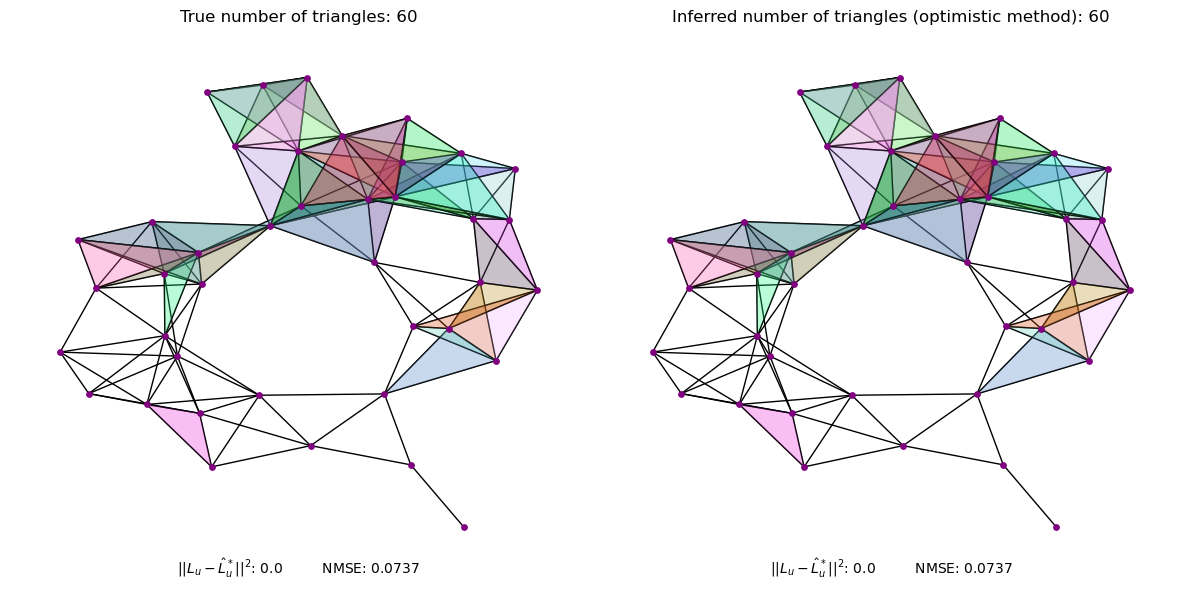

In [ ]:
plot_learnt_topology(G, Lu, B2_true, model, model)

In [ ]:
import pickle

with open("results\\final\\resT20.pkl", "rb") as f:
    models = pickle.load(f)
    res = pickle.load(f)

In [ ]:
plot_error_curves(res, K0_coll)

NameError: name 'plot_error_curves' is not defined

# Class

In [ ]:
import scipy.linalg as sla
import numpy as np
import numpy.linalg as la
import cvxpy as cp
from tsplearn.tsp_generation import *
from tsplearn.tsp_utils import *
from tsplearn.tsp_hodgelet import *  # SeparateHodgelet, SimplicianSlepians
from tsplearn.EnhancedGraph import EnhancedGraph
from typing import Tuple, List, Union, Dict
import pickle
from functools import wraps
from einops import rearrange


class TspSolver:

    def __init__(self, X_train, X_test, Y_train, Y_test, *args, **kwargs):

        params = {
            "P": None,  # Number of Kernels (Sub-dictionaries)
            "J": None,  # Polynomial order
            "K0": None,  # Sparsity level
            "dictionary_type": None,
            "c": None,  # spectral control parameter
            "epsilon": None,  # spectral control parameter
            "n": 10,  # number of nodes
            "sub_size": None,  # Number of sub-sampled nodes
            "true_prob_T": 1.0,  # True ratio of colored triangles
            "prob_T": 1.0, # The triangle probability with which we want to bias our topology
            "p_edges": 1.0,  # Probability of edge existence
            "seed": None,  ####
            "option": "One-shot-diffusion",  ####
            "diff_order_sol": 1,  ####
            "diff_order_irr": 1,  ####
            "step_prog": 1,  ####
            "top_k_slepians": 2,  ####
        }

        self.testing_trace = {} ##################################################################

        if args:
            if len(args) != 1 or not isinstance(args[0], dict):
                raise ValueError(
                    "When using positional arguments, must provide a single dictionary"
                )
            params.update(args[0])

        params.update(kwargs)

        # Data
        self.X_train: np.ndarray = X_train
        self.X_test: np.ndarray = X_test
        self.Y_train: np.ndarray = Y_train
        self.Y_test: np.ndarray = Y_test
        self.m_train: int = Y_train.shape[1]
        self.m_test: int = Y_test.shape[1]

        # Topology and geometry behind data (by default we consider a topology with full upper laplacian)
        self.G = EnhancedGraph(
            n=params["n"],
            p_edges=params["p_edges"],
            p_triangles=params["prob_T"],
            seed=params["seed"],
        )
        # Incidence matrices
        self.B1: np.ndarray = self.G.get_b1()
        self.B2: np.ndarray = self.G.get_b2()

        # Sub-sampling if needed to decrease complexity
        if params["sub_size"] != None:
            self.B1 = self.B1[:, : params["sub_size"]]
            self.B2 = self.B2[: params["sub_size"], :]
            self.B2 = self.B2[:, np.sum(np.abs(self.B2), 0) == 3]

        # Topology dimensions and hyperparameters
        self.nu: int = self.B2.shape[1]
        self.nd: int = self.B1.shape[1]
        self.true_prob_T = params["true_prob_T"]
        self.T: int = int(np.ceil(self.nu * (1 - self.true_prob_T)))

        # Laplacians according to the Hodge Theory for cell complexes
        Lu, Ld, L = self.G.get_laplacians(sub_size=params["sub_size"])
        self.Lu: np.ndarray = Lu  # Upper Laplacian
        self.Ld: np.ndarray = Ld  # Lower Laplacian
        self.L: np.ndarray = L  # Sum Laplacian
        self.M = L.shape[0]

        # Dictionary hyperparameters
        self.P = params["P"]  # Number of sub-dicts
        self.J = params["J"]  # Polynomial order for the Hodge Laplacian
        self.c = params["c"]  # Hyperparameter for stability in frequency domain
        self.epsilon = params[
            "epsilon"
        ]  # Hyperparameter for stability in frequency domain
        self.K0 = params["K0"]  # Assumed sparsity level
        self.dictionary_type = params["dictionary_type"]
        # Init optimal values for sparse representations and overcomplete dictionary
        self.D_opt: np.ndarray = np.zeros((self.M, self.M * self.P))
        self.X_opt_train: np.ndarray = np.zeros(self.X_train.shape)
        self.X_opt_test: np.ndarray = np.zeros(self.X_test.shape)
        # Init the learning errors and error curve (history)
        self.min_error_train = 1e20
        self.min_error_test = 1e20
        self.train_history: List[np.ndarray] = []
        self.test_history: List[np.ndarray] = []
        # self.opt_upper = self.nu

        ############################################################################################################
        ##                                                                                                        ##
        ##               This section is only for learnable (data-driven) dictionaries                            ##
        ##                                                                                                        ##
        ############################################################################################################

        # Init the dictionary parameters according to the specific parameterization setup
        if self.dictionary_type == "separated":
            hs = np.zeros((self.P, self.J)) # multiplicative coefficients for Upper Laplacian
            hi = np.zeros((self.P, self.J)) # multiplicative coefficients for Lower Laplacian
            hh = np.zeros((self.P, 1))      # multiplicative coefficients for identity matrix
            self.h_opt: List[np.ndarray] = [hh, hs, hi]
        else:
            h = np.zeros((self.P, self.J))
            hi = np.zeros((self.P, 1))
            self.h_opt: List[np.ndarray] = [hi, h]

        # Compute the polynomial extension for the Laplacians and the auxiliary
        # "pseudo-vandermonde" matrix for the constraints in the quadratic form
        if self.dictionary_type == "joint":
            self.Lj, self.lambda_max_j, self.lambda_min_j = compute_Lj_and_lambdaj(
                self.L, self.J
            )
            self.B = compute_vandermonde(self.L, self.J).real
        elif self.dictionary_type == "edge_laplacian":
            self.Lj, self.lambda_max_j, self.lambda_min_j = compute_Lj_and_lambdaj(
                self.Ld, self.J
            )
            self.B = compute_vandermonde(self.Ld, self.J).real
        elif self.dictionary_type == "separated":
            self.Luj, self.lambda_max_u_j, self.lambda_min_u_j = compute_Lj_and_lambdaj(
                self.Lu, self.J, separated=True
            )
            self.Ldj, self.lambda_max_d_j, self.lambda_min_d_j = compute_Lj_and_lambdaj(
                self.Ld, self.J, separated=True
            )
            self.Bu = compute_vandermonde(self.Lu, self.J).real
            self.Bd = compute_vandermonde(self.Ld, self.J)[:, 1:].real
            self.B = np.hstack([self.Bu, self.Bd])

        # Auxiliary matrix to define quadratic form dor the dictionary learning step
        self.P_aux: np.ndarray = None
        # Flag variable: the dictionary is learnable or analytic
        self.dict_is_learnable = self.dictionary_type in [
            "separated",
            "joint",
            "edge_laplacian",
        ]

        # Auxiliary tools for the Slepians-based dictionary setup
        if self.dictionary_type == "slepians":
            self.option = params["option"]
            self.diff_order_sol = params["diff_order_sol"]
            self.step_prog = params["step_prog"]
            self.diff_order_irr = params["diff_order_irr"]
            self.source_sol = np.ones((self.nd,))
            self.source_irr = np.ones((self.nd,))
            self.top_K_slepians = params["top_k_slepians"]
            self.spars_level = list(range(10, 80, 10))
            # Remember that this part should be updated if B2 or Lu are updated!
            self.F_sol, self.F_irr = get_frequency_mask(
                self.B1, self.B2
            )  # Get frequency bands
            self.S_neigh, self.complete_coverage = cluster_on_neigh(
                self.B1,
                self.B2,
                self.diff_order_sol,
                self.diff_order_irr,
                self.source_sol,
                self.source_irr,
                self.option,
                self.step_prog,
            )
            self.R = [self.F_sol, self.F_irr]
            self.S = self.S_neigh

        # Auxiliary tools for the Wavelet-based dictionary setup
        elif self.dictionary_type == "wavelet":
            # Remember that this part should be updated if B2 or Lu are updated!
            self.w1 = np.linalg.eigvalsh(self.Lu)
            self.w2 = np.linalg.eigvalsh(self.Ld)

    def update_Lu(self, Lu_new):
        self.Lu = Lu_new
        self.Luj, self.lambda_max_u_j, self.lambda_min_u_j = compute_Lj_and_lambdaj(
            self.Lu, self.J, separated=True
        )
        self.Bu = compute_vandermonde(self.Lu, self.J).real
        self.B = np.hstack([self.Bu, self.Bd])

    def init_hu(self):
        """ 
        Initialize the dictionary coefficients corresponding to the Upper Laplacian
        to avoid ill-initialization during the learning step of the Upper Laplacian
        in 'pessimistic' mode
        """
        # If find bad intialization, i.e. all zeros we need some action
        if np.sum(np.abs(self.h_opt[1])) == 0:
            # Check if the mean of the coefficients for the Lower Laplacian is a good candidate
            init_val = np.mean(self.h_opt[2])
            if init_val == 0:
                self.h_opt[1] = np.full((self.P, self.J), np.max(self.h_opt[2]))
            else:
                self.h_opt[1] = np.full((self.P, self.J),  init_val)

    @staticmethod
    def _multiplier_search(*arrays, P, c, epsilon):
        is_okay = 0
        mult = 100
        tries = 0
        while is_okay == 0:
            is_okay = 1
            h, c_try, _, tmp_sum_min, tmp_sum_max = generate_coeffs(
                arrays, P=P, mult=mult
            )
            if c_try <= c:
                is_okay *= 1
            if tmp_sum_min > c - epsilon:
                is_okay *= 1
                incr_mult = 0
            else:
                is_okay = is_okay * 0
                incr_mult = 1
            if tmp_sum_max < c + epsilon:
                is_okay *= 1
                decr_mult = 0
            else:
                is_okay *= 0
                decr_mult = 1
            if is_okay == 0:
                tries += 1
            if tries > 3:
                discard = 1
                break
            if incr_mult == 1:
                mult *= 2
            if decr_mult == 1:
                mult /= 2
        return h, discard

    def init_dict(
        self, h_prior: np.ndarray = None, mode: str = "only_X"
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Initialize the dictionary and the signal sparse representation for the alternating
        optimization algorithm.

        Args:
            Lu (np.ndarray): Upper Laplacian matrix
            Ld (np.ndarray): Lower Laplacian matrix
            P (int): Number of kernels (sub-dictionaries).
            J (int): Max order of the polynomial for the single sub-dictionary.
            Y_train (np.ndarray): Training data.
            K0 (int): Sparsity of the signal representation.
            dictionary_type (str): Type of dictionary.
            c (float): Boundary constant from the synthetic data generation process.
            epsilon (float): Boundary constant from the synthetic data generation process.
            only (str): Type of initialization. Can be one of: "only_X", "all", "only_D".

        Returns:
            Tuple[np.ndarray, np.ndarray, bool]: Initialized dictionary, initialized sparse representation, and discard flag value.
        """

        # If no prior info on the dictionary
        if np.all(h_prior == None):

            # Init Dictionary
            if mode in ["all", "only_D"]:

                discard = 1
                while discard == 1:

                    if self.dictionary_type != "separated":
                        h_prior, discard = self._multiplier_search(
                            self.lambda_max_j,
                            self.lambda_min_j,
                            P=self.P,
                            c=self.c,
                            epsilon=self.epsilon,
                        )
                        self.D_opt = generate_dictionary(h_prior, self.P, self.Lj)

                    else:
                        h_prior, discard = self._multiplier_search(
                            self.lambda_max_d_j,
                            self.lambda_min_d_j,
                            self.lambda_max_u_j,
                            self.lambda_min_u_j,
                            P=self.P,
                            c=self.c,
                            epsilon=self.epsilon,
                        )
                        self.D_opt = generate_dictionary(
                            h_prior, self.P, self.Luj, self.Ldj
                        )

            # Init Sparse Representations
            if mode in ["all", "only_X"]:

                L = self.Ld if self.dictionary_type == "edge_laplacian" else self.L
                _, Dx = sla.eig(L)
                dd = la.norm(Dx, axis=0)
                W = np.diag(1.0 / dd)
                Dx = Dx / la.norm(Dx)
                Domp = Dx @ W
                X = np.apply_along_axis(
                    lambda x: get_omp_coeff(self.K0, Domp.real, x),
                    axis=0,
                    arr=self.Y_train,
                )
                X = np.tile(X, (self.P, 1))
                self.X_opt_train = X

        # Otherwise use prior info about the dictionary to initialize both the dictionary and the sparse representation
        else:

            self.h_opt = h_prior

            if self.dictionary_type == "separated":
                self.D_opt = generate_dictionary(h_prior, self.P, self.Luj, self.Ldj)
                self.X_opt_train = sparse_transform(self.D_opt, self.K0, self.Y_train)
            else:
                self.D_opt = generate_dictionary(h_prior, self.P, self.Lj)
                self.X_opt_train = sparse_transform(self.D_opt, self.K0, self.Y_train)


    def topological_dictionary_learn(
        self,
        lambda_: float = 1e-3,
        max_iter: int = 10,
        patience: int = 10,
        tol: float = 1e-7,
        step_h: float = 1.0,
        step_x: float = 1.0,
        solver: str = "MOSEK",
        verbose: bool = False,
    ) -> Tuple[np.ndarray, np.ndarray, List[float]]:
        """
        Dictionary learning algorithm implementation for sparse representations of a signal on complex regular cellular.
        The algorithm consists of an iterative alternating optimization procedure defined in two steps: the positive semi-definite programming step
        for obtaining the coefficients and dictionary based on Hodge theory, and the Orthogonal Matching Pursuit step for constructing
        the K0-sparse solution from the dictionary found in the previous step, which best approximates the original signal.
        Args:
            Y_train (np.ndarray): Training data.
            Y_test (np.ndarray): Testing data.
            J (int): Max order of the polynomial for the single sub-dictionary.
            M (int): Number of data points (number of nodes in the data graph).
            P (int): Number of kernels (sub-dictionaries).
            D0 (np.ndarray): Initial dictionary.
            X0 (np.ndarray): Initial sparse representation.
            Lu (np.ndarray): Upper Laplacian matrix
            Ld (np.ndarray): Lower Laplacian matrix
            dictionary_type (str): Type of dictionary.
            c (float): Boundary constant from the synthetic data generation process.
            epsilon (float): Boundary constant from the synthetic data generation process.
            K0 (int): Sparsity of the signal representation.
            lambda_ (float, optional): Regularization parameter. Defaults to 1e-3.
            max_iter (int, optional): Maximum number of iterations. Defaults to 10.
            patience (int, optional): Patience for early stopping. Defaults to 10.
            tol (float, optional): Tolerance value. Defaults to 1e-s.
            verbose (int, optional): Verbosity level. Defaults to 0.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
            minimum training error, minimum testing error, optimal coefficients, optimal testing sparse representation, and optimal training sparse representation.
        """

        # Define hyperparameters
        iter_, pat_iter = 1, 0
        train_hist = []
        test_hist = []

        if self.dict_is_learnable:

            # Init the dictionary and the sparse representation
            D_coll = [
                cp.Constant(self.D_opt[:, (self.M * i) : (self.M * (i + 1))])
                for i in range(self.P)
            ]
            Dsum = cp.Constant(np.zeros((self.M, self.M)))
            h_opt = self.h_opt
            Y = cp.Constant(self.Y_train)
            X_tr = self.X_opt_train
            X_te = self.X_opt_test
            I = cp.Constant(np.eye(self.M))

            while pat_iter < patience and iter_ <= max_iter:

                # SDP Step
                X = cp.Constant(X_tr)
                if iter_ != 1:
                    D_coll = [
                        cp.Constant(D[:, (self.M * i) : (self.M * (i + 1))])
                        for i in range(self.P)
                    ]
                    Dsum = cp.Constant(np.zeros((self.M, self.M)))

                # Define the objective function
                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    # Init the variables
                    h = cp.Variable((self.P, self.J))
                    hI = cp.Variable((self.P, 1))
                    h.value, hI.value = h_opt
                    for i in range(0, self.P):
                        tmp = cp.Constant(np.zeros((self.M, self.M)))
                        for j in range(0, self.J):
                            tmp += cp.Constant(self.Lj[j, :, :]) * h[i, j]
                        tmp += I * hI[i]
                        D_coll[i] = tmp
                        Dsum += tmp
                    D = cp.hstack([D_coll[i] for i in range(self.P)])
                    term1 = cp.square(cp.norm((Y - D @ X), "fro"))
                    term2 = cp.square(cp.norm(h, "fro") * lambda_)
                    term3 = cp.square(cp.norm(hI, "fro") * lambda_)
                    obj = cp.Minimize(term1 + term2 + term3)

                else:
                    # Init the variables
                    hI = cp.Variable((self.P, self.J))
                    hS = cp.Variable((self.P, self.J))
                    hH = cp.Variable((self.P, 1))
                    hH.value, hS.value, hI.value = h_opt
                    for i in range(0, self.P):
                        tmp = cp.Constant(np.zeros((self.M, self.M)))
                        for j in range(0, self.J):
                            tmp += (cp.Constant(self.Luj[j, :, :]) * hS[i, j]) + (
                                cp.Constant(self.Ldj[j, :, :]) * hI[i, j]
                            )
                        tmp += I * hH[i]
                        D_coll[i] = tmp
                        Dsum += tmp
                    D = cp.hstack([D_coll[i] for i in range(self.P)])

                    term1 = cp.square(cp.norm((Y - D @ X), "fro"))
                    term2 = cp.square(cp.norm(hI, "fro") * lambda_)
                    term3 = cp.square(cp.norm(hS, "fro") * lambda_)
                    term4 = cp.square(cp.norm(hH, "fro") * lambda_)
                    obj = cp.Minimize(term1 + term2 + term3 + term4)

                # Define the constraints
                constraints = (
                    [D_coll[i] >> 0 for i in range(self.P)]
                    + [(cp.multiply(self.c, I) - D_coll[i]) >> 0 for i in range(self.P)]
                    + [
                        (Dsum - cp.multiply((self.c - self.epsilon), I)) >> 0,
                        (cp.multiply((self.c + self.epsilon), I) - Dsum) >> 0,
                    ]
                )

                prob = cp.Problem(obj, constraints)
                prob.solve(solver=eval(f"cp.{solver}"), verbose=False)

                # Dictionary Update
                D = D.value
                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    h_opt = [
                        h_opt[0] + step_h * (h.value - h_opt[0]),
                        h_opt[1] + step_h * (hI.value - h_opt[1]),
                    ]
                else:
                    h_opt = [
                        h_opt[0] + step_h * (hH.value - h_opt[0]),
                        h_opt[1] + step_h * (hS.value - h_opt[1]),
                        h_opt[2] + step_h * (hI.value - h_opt[2]),
                    ]

                # OMP Step
                X_te_tmp, X_tr_tmp = sparse_transform(
                    D, self.K0, self.Y_test, self.Y_train
                )
                # Sparse Representation Update
                X_tr = X_tr + step_x * (X_tr_tmp - X_tr)
                X_te = X_te + step_x * (X_te_tmp - X_te)

                # Error Update
                error_train = nmse(D, X_tr, self.Y_train, self.m_train)
                error_test = nmse(D, X_te, self.Y_test, self.m_test)
                train_hist.append(error_train)
                test_hist.append(error_test)


                # Error Storing
                if (
                    (error_train < self.min_error_train)
                    and (abs(error_train) > np.finfo(float).eps)
                    and (abs(error_train - self.min_error_train) > tol)
                ):
                    self.X_opt_train = X_tr
                    self.min_error_train = error_train

                if (
                    (error_test < self.min_error_test)
                    and (abs(error_test) > np.finfo(float).eps)
                    and (abs(error_test - self.min_error_test) > tol)
                ):
                    self.h_opt = h_opt
                    self.D_opt = D
                    self.X_opt_test = X_te
                    self.min_error_test = error_test
                    pat_iter = 0

                    if verbose == 1:
                        print("New Best Test Error:", self.min_error_test)
                else:
                    pat_iter += 1

                iter_ += 1

        else:

            # Fourier Dictionary Benchmark
            _, self.D_opt = sla.eigh(self.L)
            self.X_opt_test, self.X_opt_train = sparse_transform(
                self.D_opt, self.K0, self.Y_test, self.Y_train
            )

            # Error Updating
            self.min_error_train = nmse(
                self.D_opt, self.X_opt_train, self.Y_train, self.m_train
            )
            self.min_error_test = nmse(
                self.D_opt, self.X_opt_test, self.Y_test, self.m_test
            )

            train_hist.append(error_train)
            test_hist.append(error_test)

        return self.min_error_test, self.min_error_train, train_hist, test_hist
    

    def _aux_matrix_update(self, X):

        I = [np.eye(self.M)]
        if self.dictionary_type == "separated":
            LLu = [lu for lu in self.Luj]
            LLd = [ld for ld in self.Ldj]
            LL = np.array(I + LLu + LLd)
        else:
            LL = [l for l in self.Lj]
            LL = np.array(I + LL)

        P_aux = np.array(
            [LL @ X[(i * self.M) : ((i + 1) * self.M), :] for i in range(self.P)]
        )
        self.P_aux = rearrange(P_aux, "b h w c -> (b h) w c")

    def topological_dictionary_learn_qp(
        self,
        lambda_: float = 1e-3,
        max_iter: int = 10,
        patience: int = 10,
        tol: float = 1e-7,
        solver: str = "GUROBI",
        step_h: float = 1.0,
        step_x: float = 1.0,
        verbose: bool = False,
    ) -> Tuple[np.ndarray, np.ndarray, List[float]]:

        # Define hyperparameters
        iter_, pat_iter = 1, 0
        train_hist = []
        test_hist = []

        # Learnable Dictionary -> alternating-direction optimization algorithm
        if self.dict_is_learnable:

            # Init the the sparse representation
            h_opt = np.hstack([h.flatten() for h in self.h_opt]).reshape(-1, 1)
            X_tr = self.X_opt_train
            X_te = self.X_opt_test
            f = 2 if self.dictionary_type == "separated" else 1
            reg = lambda_ * np.eye(self.P * (f * self.J + 1))
            I_s = cp.Constant(np.eye(self.P))
            i_s = cp.Constant(np.ones((self.P, 1)))
            B = cp.Constant(self.B)

            while pat_iter < patience and iter_ <= max_iter:

                # Init variables and parameters
                h = cp.Variable((self.P * (f * self.J + 1), 1))
                self._aux_matrix_update(X_tr)
                h.value = h_opt

                Q = cp.Constant(
                    np.einsum("imn, lmn -> il", self.P_aux, self.P_aux) + reg
                )
                l = cp.Constant(np.einsum("mn, imn -> i", self.Y_train, self.P_aux))

                # Quadratic term
                term2 = cp.quad_form(h, Q, assume_PSD=True)
                # Linear term
                term1 = l @ h
                term1 = cp.multiply(-2, term1)[0]

                obj = cp.Minimize(term2 + term1)

                # Define the constraints
                cons1 = cp.kron(I_s, B) @ h
                cons2 = cp.kron(i_s.T, B) @ h
                constraints = (
                    [cons1 >= 0]
                    + [cons1 <= self.c]
                    + [cons2 >= (self.c - self.epsilon)]
                    + [cons2 <= (self.c + self.epsilon)]
                )

                prob = cp.Problem(obj, constraints)
                prob.solve(solver=eval(f"cp.{solver}"), verbose=False)

                # Update the dictionary

                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    h_tmp = split_coeffs(h, self.P, self.J)
                    # print(h_tmp.shape)
                    # h_tmp = h.value.reshape(self.P, self.J+1)
                    D = generate_dictionary(h_tmp, self.P, self.Lj)
                    h_opt = h_opt + step_h * (h.value - h_opt)
                else:

                    h_list = split_coeffs(h, self.P, self.J, sep=True)
                    D = generate_dictionary(h_list, self.P, self.Luj, self.Ldj)
                    h_opt = h_opt + step_h * (h.value - h_opt)

                # OMP Step
                X_te_tmp, X_tr_tmp = sparse_transform(
                    D, self.K0, self.Y_test, self.Y_train
                )
                # Sparse Representation Update
                X_tr = X_tr + step_x * (X_tr_tmp - X_tr)
                X_te = X_te + step_x * (X_te_tmp - X_te)

                # Error Update
                error_train = nmse(D, X_tr, self.Y_train, self.m_train)
                error_test = nmse(D, X_te, self.Y_test, self.m_test)

                train_hist.append(error_train)
                test_hist.append(error_test)

                # Error Storing
                if (
                    (error_train < self.min_error_train)
                    and (abs(error_train) > np.finfo(float).eps)
                    and (abs(error_train - self.min_error_train) > tol)
                ):
                    self.X_opt_train = X_tr
                    self.min_error_train = error_train

                if (
                    (error_test < self.min_error_test)
                    and (abs(error_test) > np.finfo(float).eps)
                    and (abs(error_test - self.min_error_test) > tol)
                ):
                    self.h_opt = (
                        h_list if self.dictionary_type == "separated" else h_opt
                    )
                    self.D_opt = D
                    self.X_opt_test = X_te
                    self.min_error_test = error_test
                    pat_iter = 0

                    if verbose == 1:
                        print("New Best Test Error:", self.min_error_test)
                else:
                    pat_iter += 1

                iter_ += 1

        # Analytic Dictionary -> directly go to OMP step
        else:

            if self.dictionary_type == "fourier":
                # Fourier Dictionary Benchmark
                _, self.D_opt = sla.eigh(self.L)

            elif self.dictionary_type == "slepians":
                SS = SimplicianSlepians(
                    self.B1,
                    self.B2,
                    self.S,
                    self.R,
                    verbose=False,
                    top_K=self.top_K_slepians,
                )
                self.D_opt = SS.atoms_flat

            elif self.dictionary_type == "wavelet":
                SH = SeparateHodgelet(
                    self.B1,
                    self.B2,
                    *log_wavelet_kernels_gen(3, 4, np.log(np.max(self.w1))),
                    *log_wavelet_kernels_gen(3, 4, np.log(np.max(self.w2))),
                )
                self.D_opt = SH.atoms_flat
                # print(self.D_opt.shape)

            # OMP
            self.X_opt_test, self.X_opt_train = sparse_transform(
                self.D_opt, self.K0, self.Y_test, self.Y_train
            )
            # Error Updating
            self.min_error_train = nmse(
                self.D_opt, self.X_opt_train, self.Y_train, self.m_train
            )
            self.min_error_test = nmse(
                self.D_opt, self.X_opt_test, self.Y_test, self.m_test
            )
            
            train_hist.append(self.min_error_train)
            test_hist.append(self.min_error_test)

        return self.min_error_test, self.min_error_train, train_hist, test_hist
    

    def learn_upper_laplacian(
        self,
        Lu_new: np.ndarray = None,
        filter: np.ndarray = 1,
        lambda_: float = 1e-3,
        max_iter: int = 10,
        patience: int = 10,
        tol: float = 1e-7,
        step_h: float = 1.0,
        step_x: float = 1.0,
        mode: str = "optimistic",
        verbose: bool = False,
        warmup: int = 0,
        on_test: bool = True,
        QP=False
    ):

        assert step_h < 1 or step_h > 0, "You must provide a step-size between 0 and 1."
        assert step_x < 1 or step_x > 0, "You must provide a step-size between 0 and 1."
        assert (mode == "optimistic") or (mode == "pessimistic"), f'{mode} is not a legal mode: "optimistic" or "pessimistic" are the only ones allowed.'

        # Check if we are executing the first recursive iteration
        if np.all(Lu_new == None):
            T = self.B2.shape[1]
            self.warmup = warmup
            self.opt_upper = 0
            if mode == "optimistic":
                filter = np.ones(T)
            elif mode == "pessimistic":
                filter = np.zeros(T)
                self.update_Lu(np.zeros(self.Lu.shape))  # start with an "empty" upper Laplacian

        else:
            if mode == "pessimistic":
                self.init_hu()
            self.update_Lu(Lu_new)

        if QP:
            _, _, train_hist, test_hist = self.topological_dictionary_learn_qp(
                lambda_=lambda_,
                max_iter=max_iter,
                patience=patience,
                tol=tol,
                step_h=step_h,
                step_x=step_x,
                solver="GUROBI",
            )
        else:
            _, _, train_hist, test_hist = self.topological_dictionary_learn(
                lambda_=lambda_,
                max_iter=max_iter,
                patience=patience,
                tol=tol,
                step_h=step_h,
                step_x=step_x,
            )

        self.train_history.append(train_hist)
        self.test_history.append(test_hist)

        search_space = (
            np.where(filter == 1) if mode == "optimistic" else np.where(filter == 0)
        )
        sigmas = pd.DataFrame({"idx": search_space[0]})

        sigmas["sigma"] = sigmas.idx.apply(lambda _: filter)
        if mode == "optimistic":
            sigmas["sigma"] = sigmas.apply(lambda x: indicator_matrix(x), axis=1)
        else:
            sigmas["sigma"] = sigmas.apply(lambda x: indicator_matrix_rev(x), axis=1)
        sigmas["Luj"] = sigmas.apply(lambda x: compute_Luj(x, self.B2, self.J), axis=1)
        sigmas["D"] = sigmas.apply(
            lambda x: generate_dictionary(self.h_opt, self.P, x.Luj, self.Ldj), axis=1
        )
        if on_test:
            sigmas["X"] = sigmas.D.apply(
                lambda x: sparse_transform(x, self.K0, self.Y_test)
            )
            sigmas["NMSE"] = sigmas.apply(
                lambda x: nmse(x.D, x.X, self.Y_test, self.m_test), axis=1
            )
        else:
            sigmas["X"] = sigmas.D.apply(
                lambda x: sparse_transform(x, self.K0, self.Y_train)
            )
            sigmas["NMSE"] = sigmas.apply(
                lambda x: nmse(x.D, x.X, self.Y_train, self.m_train), axis=1
            )

        candidate_error = sigmas.NMSE.min()
        current_min = self.min_error_test if on_test else self.min_error_train
        idx_min = sigmas.NMSE.idxmin()
        # If in warmup look at the third decimal point
        if self.warmup > 0:
            candidate_error = int(candidate_error*1000)
            current_min = int(current_min*1000)
            self.warmup -= 1

        # self.testing_trace[f'{self.opt_upper}'] = (sigmas, current_min, candidate_error)
        if candidate_error <= current_min:
            S = sigmas.sigma[idx_min]
            Lu_new = self.B2 @ S @ self.B2.T
            filter = np.diagonal(S)
            self.opt_upper += 1

            if verbose:
                if mode == "optimistic":
                    print(
                        f"Removing {self.opt_upper} triangles from the topology... \n ... The min error: {candidate_error:.3f} !"
                    )
                else:
                    print(
                        f"Adding {self.opt_upper} triangles to the topology... \n ... The min error: {candidate_error:.3f} !"
                    )

            self.testing_trace[f'{self.opt_upper}'] = (S, Lu_new) # return the filter flattened matrix and the new best Lu_new

            return self.learn_upper_laplacian(
                Lu_new=Lu_new,
                filter=filter,
                lambda_=lambda_,
                max_iter=max_iter,
                patience=patience,
                tol=tol,
                step_h=step_h,
                step_x=step_x,
                mode=mode,
                verbose=verbose,
                on_test=on_test,
                QP=QP
            )

        self.B2 = self.B2 @ np.diag(filter)
        return self.min_error_train, self.min_error_test, self.train_history, self.test_history, self.Lu, self.B2
    
    def save_results(func):
        '''Decorator to save intermediate results when testing learning functions
        '''
        @wraps(func)
        def wrapper(self, *args, **kwargs):

            outputs = func(self, *args, **kwargs)
            func_name = func.__name__

            if func_name == "test_topological_dictionary_learn":

                path = os.getcwd()
                dir_path = os.path.join(
                    path, "results", "dictionary_learning", f"{self.dictionary_type}"
                )
                name = f"learn_D_{self.dictionary_type}"
                filename = os.path.join(dir_path, f"{name}.pkl")
                save_var = {
                    "min_error_test": self.min_error_test,
                    "min_error_train": self.min_error_train,
                    "train_history": outputs[2],
                    "test_history": outputs[3],
                    "h_opt": self.h_opt,
                    "X_opt_test": self.X_opt_test,
                    "X_opt_train": self.X_opt_train,
                    "D_opt": self.D_opt,
                }

            elif func_name == "test_topological_dictionary_learn_qp":

                path = os.getcwd()
                dir_path = os.path.join(path, "results", "no_topology_learning")
                name = f"learn_T{int(self.true_prob_T*100)}"
                filename = os.path.join(dir_path, f"{name}.pkl")
                save_var = {
                    "min_error_test": self.min_error_test,
                    "min_error_train": self.min_error_train,
                    "train_history": outputs[2],
                    "test_history": outputs[3],
                    "h_opt": self.h_opt,
                    "X_opt_test": self.X_opt_test,
                    "X_opt_train": self.X_opt_train,
                    "D_opt": self.D_opt,
                }

            elif func_name == "test_learn_upper_laplacian":

                path = os.getcwd()
                dir_path = os.path.join(path, "results", "topology_learning")
                name = f"learn_T{int(self.true_prob_T*100)}"
                filename = os.path.join(dir_path, f"{name}.pkl")
                save_var = {
                    "min_error_test": self.min_error_test,
                    "min_error_train": self.min_error_train,
                    "train_history": self.train_history,
                    "test_history": self.test_history,
                    "Lu_opt": self.Lu,
                    "B2_opt":self.B2,
                    "h_opt": self.h_opt,
                    "X_opt_test": self.X_opt_test,
                    "X_opt_train": self.X_opt_train,
                    "D_opt": self.D_opt,
                }

            if not os.path.exists(dir_path):
                os.makedirs(dir_path)

            try:
                with open(filename, "wb") as file:
                    pickle.dump(save_var, file)
            except IOError as e:
                print(f"An error occurred while writing the file: {e}")
            except Exception as e:
                print(f"An unexpected error occurred: {e}")

            return outputs

        return wrapper
    
    @save_results
    def test_topological_dictionary_learn(
        self,
        mode: str = "only_X",
        lambda_: float = 1e-7,
        max_iter: int = 100,
        patience: int = 5,
        tol: float = 1e-7,
        solver: str = "MOSEK",
        step_h: float = 1.0,
        step_x: float = 1.0,
        verbose: bool = False,
    ) -> None:
        
        try:
            self.init_dict(mode=mode)
        except:
            print("Initialization Failed!")
        
        self.topological_dictionary_learn(
            lambda_,
            max_iter,
            patience,
            tol,
            solver,
            step_h,
            step_x,
            verbose
            )
            
    @save_results
    def test_topological_dictionary_learn_qp(
        self,
        mode: str = "only_X",
        lambda_: float = 1e-7,
        max_iter: int = 100,
        patience: int = 5,
        tol: float = 1e-7,
        solver: str = "GUROBI",
        step_h: float = 1.0,
        step_x: float = 1.0,
        verbose: bool = False,
    ) -> None:
        
        try:
            self.init_dict(mode=mode)
        except:
            print("Initialization Failed!")

        self.topological_dictionary_learn_qp(
            lambda_,
            max_iter,
            patience,
            tol,
            solver,
            step_h,
            step_x,
            verbose
            )
        
    @save_results
    def test_learn_upper_laplacian(
        self,
        init_mode: str = "only_X",
        lambda_: float = 1e-7,
        max_iter: int = 100,
        patience: int = 5,
        tol: float = 1e-7,
        step_h: float = 1.,
        step_x: float = 1.,
        mode: str = "optimistic",
        verbose: bool = True,
        warmup: int = 0,
        QP: bool = True
    ) -> None:

        try:
            self.init_dict(mode=init_mode)
        except:
            print("Initialization Failed!")

        self.learn_upper_laplacian(
            lambda_=lambda_,
            max_iter=max_iter,
            patience=patience,
            tol=tol,
            step_h=step_h,
            step_x=step_x,
            mode=mode,
            verbose=verbose,
            warmup=warmup,
            QP=QP
            )
        
    def get_topology_approx_error(self, Lu_true):
        return np.linalg.norm(Lu_true-self.Lu, ord="fro")
    
    def fit(self, Lu_true, init_mode="only_X", learn_topology=True, **hyperparams):

        hp = {"lambda_":1e-7,
              "tol":1e-7,
              "patience":5,
              "max_iter":100,
              "step_x":1.,
              "step_h":1.,
              "QP":True,
              "mode":"optimistic",
              "verbose":False,
              "on_test":False
              }
        
        hp.update(hyperparams)

        try:
            self.init_dict(mode=init_mode)
        except:
            print("Initialization Failed!")
        
        if learn_topology:
            self.learn_upper_laplacian(
                lambda_=hp["lambda_"],
                max_iter=hp["max_iter"],
                patience=hp["patience"],
                tol=hp["tol"],
                step_h=hp["step_h"],
                step_x=hp["step_x"],
                mode=hp["mode"],
                verbose=hp["verbose"],
                warmup=hp["warmup"],
                on_test=hp["on_test"],
                QP=hp["QP"]
            )

        else:
            self.topological_dictionary_learn_qp(
                lambda_=hp["lambda_"],
                max_iter=hp["max_iter"],
                patience=hp["patience"],
                tol=hp["tol"],
                step_h=hp["step_h"],
                step_x=hp["step_x"],
                solver='GUROBI'
            )

        Lu_approx_error = self.get_topology_approx_error(Lu_true=Lu_true)

        return self.min_error_train, self.min_error_test, Lu_approx_error


In [ ]:
from tsplearn.utils import final_save
from tqdm import tqdm

# @final_save
def param_dict_learning(
    X_train,
    X_test,
    Y_train,
    Y_test,
    c_true,
    epsilon_true,
    n_sim,
    topo_params,
    algo_params,
    K0_coll,
    Lu_true,
    prob_T,
    complete=False,
    verbose: bool = True,
):
    """
    Learn the sparse representation and the dictionary atoms with the alternating-direction algorithm,
    for given test and training set, and comparing the performances in terms of training and test
    approximation error for several algorithmic setup, principally differencing by dictionary parameterization:
        - Fourier dictionary parameterization
        - Edge Laplacian dictionary parameterization
        - Joint Hodge Laplacian dictionary parameterization
        - Separated Hodge Laplacian dictionary parameterization
        - (Optionally) Separated Hodge Laplacian dictionary parameterization plus Topology Learning
    """

    min_error_fou_train = np.zeros((n_sim, len(K0_coll)))
    min_error_fou_test = np.zeros((n_sim, len(K0_coll)))
    min_error_sep_train = np.zeros((n_sim, len(K0_coll)))
    min_error_sep_test = np.zeros((n_sim, len(K0_coll)))
    min_error_edge_train = np.zeros((n_sim, len(K0_coll)))
    min_error_edge_test = np.zeros((n_sim, len(K0_coll)))
    min_error_joint_train = np.zeros((n_sim, len(K0_coll)))
    min_error_joint_test = np.zeros((n_sim, len(K0_coll)))
    approx_fou = np.zeros((n_sim, len(K0_coll)))
    approx_sep = np.zeros((n_sim, len(K0_coll)))
    approx_joint = np.zeros((n_sim, len(K0_coll)))
    approx_edge = np.zeros((n_sim, len(K0_coll)))
    approx_comp = np.zeros((n_sim, len(K0_coll)))
    laplacian_fou = np.zeros((n_sim, len(K0_coll)))
    laplacian_sep = np.zeros((n_sim, len(K0_coll)))
    laplacian_joint = np.zeros((n_sim, len(K0_coll)))
    laplacian_edge = np.zeros((n_sim, len(K0_coll)))
    laplacian_comp = np.zeros((n_sim, len(K0_coll)))

    dict_errors = {
        "fou": (min_error_fou_train, min_error_fou_test,approx_fou,laplacian_fou),
        "edge": (min_error_edge_train, min_error_edge_test,approx_edge,laplacian_edge),
        "joint": (min_error_joint_train, min_error_joint_test,approx_joint,laplacian_joint),
        "sep": (min_error_sep_train, min_error_sep_test,approx_sep,laplacian_sep),
    }

    dict_types = {
        "fou": ("Fourier", "fourier"),
        "edge": ("Edge Laplacian", "edge_laplacian"),
        "joint": ("Hodge Laplacian", "joint"),
        "sep": ("Separated Hodge Laplacian", "separated"),
    }

    if complete:
        min_error_complete_train = np.zeros((n_sim, len(K0_coll)))
        min_error_complete_test = np.zeros((n_sim, len(K0_coll)))
        dict_errors["comp"] = (min_error_complete_train, min_error_complete_test,approx_comp, laplacian_comp)
        dict_types["comp"] = (
            "Separated Hodge Laplacian with Topology learning",
            "separated",
        )

    models = {}

    for sim in range(n_sim):

        for k0_index, k0 in tqdm(enumerate(K0_coll)):

            for d in dict_types.items():

                model = TspSolver(
                    X_train=X_train[:, :, sim],
                    X_test=X_test[:, :, sim],
                    Y_train=Y_train[:, :, sim],
                    Y_test=Y_test[:, :, sim],
                    c=c_true[sim],
                    epsilon=epsilon_true[sim],
                    K0=k0,
                    dictionary_type=d[1][1],
                    **topo_params,
                )

                learn_topology = True if d[0]=="comp" else False

                try:

                    dict_errors[d[0]][0][sim, k0_index], dict_errors[d[0]][1][sim, k0_index], dict_errors[d[0]][2][sim, k0_index] = model.fit(Lu_true=Lu_true,
                                                                                                                                                init_mode="only_X",
                                                                                                                                                learn_topology=learn_topology,
                                                                                                                                                **algo_params)
                    
                    models[f"{sim},{k0_index}"] = model

                    if verbose:
                        print(
                            f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing {d[1][0]}... Done! Test Error: {dict_errors[d[0]][1][sim,k0_index]:.3f}"
                        )
                        print(
                            f"Topology Approx. Error: {dict_errors[d[0]][2][sim,k0_index]:.3f}"
                        )

                except:
                    print(
                        f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing {d[1][0]}... Diverged!"
                    )
                    try:
                        (
                            dict_errors[d[0]][0][sim, k0_index],
                            dict_errors[d[0]][1][sim, k0_index],
                        ) = (
                            dict_errors[d[0]][0][sim - 1, k0_index],
                            dict_errors[d[0]][1][sim - 1, k0_index],
                        )
                    except:
                        (
                            dict_errors[d[0]][0][sim, k0_index],
                            dict_errors[d[0]][1][sim, k0_index],
                        ) = (
                            dict_errors[d[0]][0][sim + 1, k0_index],
                            dict_errors[d[0]][1][sim + 1, k0_index],
                        )
                        
    return dict_errors, models

In [ ]:
s=0

topo_params = {"J":J,
                "P":P,
                "c":c_true[s],
                "epsilon":epsilon_true[s],
                "true_prob_T":prob_T,
                "sub_size":100,
                "seed":0,
                "n":40,
                "K0":K0_coll[2],
                "p_edges":0.162,
                "dictionary_type": dictionary_type
                }

algo_params = {"lambda_":lambda_,
              "tol":tol,
              "patience":patience,
              "max_iter":max_iter,
              "QP":True,
              "mode":"optimistic",
              "warmup":1,
              "verbose":True,
              "on_test":False
              }


In [ ]:
T

2

In [ ]:
import warnings
warnings.filterwarnings("ignore")

topoX2 = TopoSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                **topo_params)

topoX2.fit(Lu_true=Lu,
            init_mode="only_X",
            **algo_params,
            )

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-10
Removing 1 triangles from the topology... 
 ... The min error: 13.000 !
Removing 2 triangles from the topology... 
 ... The min error: 0.013 !


(0.013083885155030535, 0.014094680218117453, 0.0)

In [ ]:
topoX2.testing_trace

{'1': (array([[1., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 1., 0., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 0., 1.]]),
  array([[ 4., -1., -1., ...,  0.,  0.,  0.],
         [-1.,  4., -1., ...,  0.,  0.,  0.],
         [-1., -1.,  3., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  1.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  1.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  1.]])),
 '2': (array([[1., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 1., 0., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 0., 1.]]),
  array([[ 4., -1., -1., ...,  0.,  0.,  0.],
         [-1.,  4., -1., ...,  0.,  0.,  0.],
         [-1., -1.,  3., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  1.

In [ ]:
np.diag(topoX2.testing_trace['2'][0])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
np.diag(G.mask)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
import warnings
warnings.filterwarnings("ignore")

algo_params_pess = {"lambda_":lambda_,
              "tol":tol,
              "patience":patience,
              "max_iter":max_iter,
              "QP":True,
              "mode":"pessimistic",
              "warmup":1,
              "verbose":True,
              "on_test":False
              }

topoX2_pess = TspSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                **topo_params)

topoX2_pess.fit(Lu_true=Lu,
            init_mode="only_X",
            **algo_params_pess,
            )

Adding 1 triangles to the topology... 
 ... The min error: 56.000 !
init hu with mean
Adding 2 triangles to the topology... 
 ... The min error: 0.056 !
Adding 3 triangles to the topology... 
 ... The min error: 0.055 !
Adding 4 triangles to the topology... 
 ... The min error: 0.055 !
Adding 5 triangles to the topology... 
 ... The min error: 0.054 !
Adding 6 triangles to the topology... 
 ... The min error: 0.054 !
Adding 7 triangles to the topology... 
 ... The min error: 0.054 !
Adding 8 triangles to the topology... 
 ... The min error: 0.054 !
Adding 9 triangles to the topology... 
 ... The min error: 0.054 !
Adding 10 triangles to the topology... 
 ... The min error: 0.054 !


(0.05343798281646876, 0.05775386620065775, 27.53179979587241)

In [ ]:
topoX2_pess.testing_trace['10'][1]

0.05343798281646876

In [ ]:
topoX2_pess.testing_trace['10'][0].NMSE.min()

0.05459952416404024

In [ ]:
topoX2_pess.h_opt

[array([[0.48458582],
        [0.32154448],
        [0.02929869]]),
 array([[-0., -0.],
        [-0., -0.],
        [-0., -0.]]),
 array([[ 0.0211103 , -0.00429297],
        [-0.07180967,  0.00419374],
        [ 0.02422258,  0.00368847]])]

In [ ]:
topoX2_pess.testing_trace['0'][0].NMSE.min()

0.05628217473174637

In [ ]:
topoX2_pess.testing_trace['1'][0].NMSE.min()

0.04500644766813186

In [ ]:
np.sum(np.abs(topoX2.h_opt[1])) == 0

True

In [ ]:
np.full((topoX2.P, topoX2.J), topoX2.h_opt[2].mean())

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

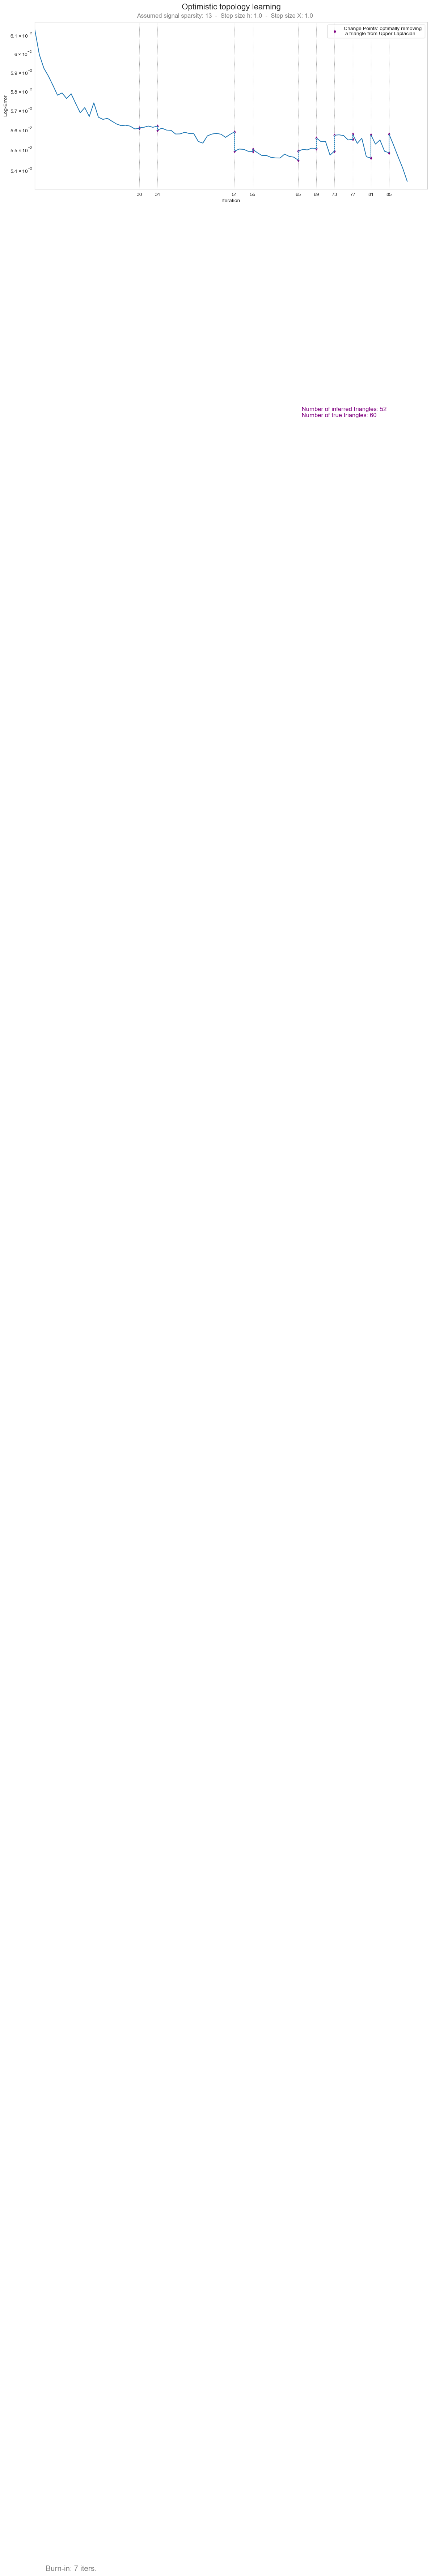

In [ ]:
plot_changepoints_curve(topoX2_pess.train_history,K0_coll[2],nu=nu,T=T,mode="optimistic",burn_in=0.2)

### Complete plot

In [ ]:
algo_params = {"lambda_":lambda_,
              "tol":tol,
              "patience":patience,
              "max_iter":max_iter,
              "QP":True,
              "mode":"optimistic",
              "warmup":1
              }

topo_params = {"J":J,
                "P":P,
                "true_prob_T":prob_T,
                "sub_size":100,
                "seed":0,
                "n":40,
                "p_edges":0.162,
                }

In [ ]:
K0_coll[3:]

array([17, 21, 25])

In [ ]:
import warnings
warnings.filterwarnings("ignore")

res, models = param_dict_learning(
    X_train=X_train,
    X_test=X_test,
    Y_train=Y_train,
    Y_test=Y_test,
    c_true=c_true,
    epsilon_true=epsilon_true,
    n_sim=n_sim,
    topo_params=topo_params,
    algo_params=algo_params,
    K0_coll=K0_coll[3:],
    Lu_true=Lu,
    prob_T=prob_T,
    complete=True
)

0it [00:00, ?it/s]

Simulation: 1/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.072
Topology Approx. Error: 4.472
Simulation: 1/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.037
Topology Approx. Error: 4.472
Simulation: 1/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.028
Topology Approx. Error: 4.472
Simulation: 1/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.009
Topology Approx. Error: 4.472


1it [06:32, 392.74s/it]

Simulation: 1/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.008
Topology Approx. Error: 0.000
Simulation: 1/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.048
Topology Approx. Error: 4.472
Simulation: 1/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.022
Topology Approx. Error: 4.472
Simulation: 1/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.016
Topology Approx. Error: 4.472
Simulation: 1/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.006
Topology Approx. Error: 4.472


2it [12:41, 378.91s/it]

Simulation: 1/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.006
Topology Approx. Error: 4.472
Simulation: 1/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.034
Topology Approx. Error: 4.472
Simulation: 1/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.014
Topology Approx. Error: 4.472
Simulation: 1/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.011
Topology Approx. Error: 4.472
Simulation: 1/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.010
Topology Approx. Error: 4.472


3it [27:33, 551.31s/it]


Simulation: 1/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.003
Topology Approx. Error: 0.000


0it [00:00, ?it/s]

Simulation: 2/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.070
Topology Approx. Error: 4.472
Simulation: 2/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.034
Topology Approx. Error: 4.472
Simulation: 2/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.028
Topology Approx. Error: 4.472
Simulation: 2/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.011
Topology Approx. Error: 4.472


1it [05:28, 328.40s/it]

Simulation: 2/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.009
Topology Approx. Error: 0.000
Simulation: 2/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.046
Topology Approx. Error: 4.472
Simulation: 2/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.022
Topology Approx. Error: 4.472
Simulation: 2/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.018
Topology Approx. Error: 4.472
Simulation: 2/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.009
Topology Approx. Error: 4.472


2it [12:46, 392.68s/it]

Simulation: 2/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.006
Topology Approx. Error: 0.000
Simulation: 2/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.032
Topology Approx. Error: 4.472
Simulation: 2/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.014
Topology Approx. Error: 4.472
Simulation: 2/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.012
Topology Approx. Error: 4.472
Simulation: 2/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.007
Topology Approx. Error: 4.472


3it [22:32, 450.94s/it]


Simulation: 2/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.005
Topology Approx. Error: 0.000


0it [00:00, ?it/s]

Simulation: 3/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.068
Topology Approx. Error: 4.472
Simulation: 3/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.027
Topology Approx. Error: 4.472
Simulation: 3/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.016
Topology Approx. Error: 4.472
Simulation: 3/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.008
Topology Approx. Error: 4.472


1it [06:10, 370.42s/it]

Simulation: 3/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.006
Topology Approx. Error: 0.000
Simulation: 3/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.044
Topology Approx. Error: 4.472
Simulation: 3/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.018
Topology Approx. Error: 4.472
Simulation: 3/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.010
Topology Approx. Error: 4.472
Simulation: 3/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.005
Topology Approx. Error: 4.472


2it [14:00, 429.14s/it]

Simulation: 3/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.004
Topology Approx. Error: 0.000
Simulation: 3/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.030
Topology Approx. Error: 4.472
Simulation: 3/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.012
Topology Approx. Error: 4.472
Simulation: 3/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.006
Topology Approx. Error: 4.472
Simulation: 3/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.004
Topology Approx. Error: 4.472


3it [21:35, 431.92s/it]


Simulation: 3/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.004
Topology Approx. Error: 3.000


0it [00:00, ?it/s]

Simulation: 4/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.071
Topology Approx. Error: 4.472
Simulation: 4/10 Sparsity: 17 Testing Edge Laplacian... Diverged!
Simulation: 4/10 Sparsity: 17 Testing Hodge Laplacian... Diverged!
Simulation: 4/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.017
Topology Approx. Error: 4.472


1it [04:41, 281.34s/it]

Simulation: 4/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.013
Topology Approx. Error: 3.000
Simulation: 4/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.046
Topology Approx. Error: 4.472
Simulation: 4/10 Sparsity: 21 Testing Edge Laplacian... Diverged!
Simulation: 4/10 Sparsity: 21 Testing Hodge Laplacian... Diverged!
Simulation: 4/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.011
Topology Approx. Error: 4.472


2it [08:36, 253.99s/it]

Simulation: 4/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.011
Topology Approx. Error: 3.000
Simulation: 4/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.032
Topology Approx. Error: 4.472
Simulation: 4/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.016
Topology Approx. Error: 4.472
Simulation: 4/10 Sparsity: 25 Testing Hodge Laplacian... Diverged!
Simulation: 4/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.009
Topology Approx. Error: 4.472


3it [14:43, 294.67s/it]


Simulation: 4/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.009
Topology Approx. Error: 3.000


0it [00:00, ?it/s]

Simulation: 5/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.081
Topology Approx. Error: 4.472
Simulation: 5/10 Sparsity: 17 Testing Edge Laplacian... Diverged!
Simulation: 5/10 Sparsity: 17 Testing Hodge Laplacian... Diverged!
Simulation: 5/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.017
Topology Approx. Error: 4.472


1it [05:06, 306.73s/it]

Simulation: 5/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.013
Topology Approx. Error: 0.000
Simulation: 5/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.055
Topology Approx. Error: 4.472
Simulation: 5/10 Sparsity: 21 Testing Edge Laplacian... Diverged!
Simulation: 5/10 Sparsity: 21 Testing Hodge Laplacian... Diverged!
Simulation: 5/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.014
Topology Approx. Error: 4.472


2it [10:47, 326.91s/it]

Simulation: 5/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.013
Topology Approx. Error: 3.000
Simulation: 5/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.037
Topology Approx. Error: 4.472
Simulation: 5/10 Sparsity: 25 Testing Edge Laplacian... Diverged!
Simulation: 5/10 Sparsity: 25 Testing Hodge Laplacian... Diverged!
Simulation: 5/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.020
Topology Approx. Error: 4.472


3it [14:09, 283.19s/it]


Simulation: 5/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.020
Topology Approx. Error: 4.472


0it [00:00, ?it/s]

Simulation: 6/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.071
Topology Approx. Error: 4.472
Simulation: 6/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.039
Topology Approx. Error: 4.472
Simulation: 6/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.027
Topology Approx. Error: 4.472
Simulation: 6/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.022
Topology Approx. Error: 4.472


1it [06:24, 384.14s/it]

Simulation: 6/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.018
Topology Approx. Error: 0.000
Simulation: 6/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.048
Topology Approx. Error: 4.472
Simulation: 6/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.025
Topology Approx. Error: 4.472
Simulation: 6/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.017
Topology Approx. Error: 4.472
Simulation: 6/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.020
Topology Approx. Error: 4.472


2it [12:50, 385.51s/it]

Simulation: 6/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.019
Topology Approx. Error: 3.000
Simulation: 6/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.033
Topology Approx. Error: 4.472
Simulation: 6/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.020
Topology Approx. Error: 4.472
Simulation: 6/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.011
Topology Approx. Error: 4.472
Simulation: 6/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.013
Topology Approx. Error: 4.472


3it [22:00, 440.29s/it]


Simulation: 6/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.011
Topology Approx. Error: 0.000


0it [00:00, ?it/s]

Simulation: 7/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.066
Topology Approx. Error: 4.472
Simulation: 7/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.035
Topology Approx. Error: 4.472
Simulation: 7/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.013
Topology Approx. Error: 4.472
Simulation: 7/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.021
Topology Approx. Error: 4.472


1it [04:40, 280.65s/it]

Simulation: 7/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.018
Topology Approx. Error: 3.000
Simulation: 7/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.046
Topology Approx. Error: 4.472
Simulation: 7/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.020
Topology Approx. Error: 4.472
Simulation: 7/10 Sparsity: 21 Testing Hodge Laplacian... Diverged!
Simulation: 7/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.017
Topology Approx. Error: 4.472


2it [11:53, 370.43s/it]

Simulation: 7/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.009
Topology Approx. Error: 0.000
Simulation: 7/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.030
Topology Approx. Error: 4.472
Simulation: 7/10 Sparsity: 25 Testing Edge Laplacian... Diverged!
Simulation: 7/10 Sparsity: 25 Testing Hodge Laplacian... Diverged!
Simulation: 7/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.012
Topology Approx. Error: 4.472


3it [15:56, 318.89s/it]


Simulation: 7/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.010
Topology Approx. Error: 3.000


0it [00:00, ?it/s]

Simulation: 8/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.078
Topology Approx. Error: 4.472
Simulation: 8/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.038
Topology Approx. Error: 4.472
Simulation: 8/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.025
Topology Approx. Error: 4.472
Simulation: 8/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.016
Topology Approx. Error: 4.472


1it [06:29, 389.23s/it]

Simulation: 8/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.014
Topology Approx. Error: 0.000
Simulation: 8/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.051
Topology Approx. Error: 4.472
Simulation: 8/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.026
Topology Approx. Error: 4.472
Simulation: 8/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.017
Topology Approx. Error: 4.472
Simulation: 8/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.010
Topology Approx. Error: 4.472


2it [14:29, 443.00s/it]

Simulation: 8/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.008
Topology Approx. Error: 0.000
Simulation: 8/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.034
Topology Approx. Error: 4.472
Simulation: 8/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.018
Topology Approx. Error: 4.472
Simulation: 8/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.011
Topology Approx. Error: 4.472
Simulation: 8/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.016
Topology Approx. Error: 4.472


3it [22:15, 445.19s/it]


Simulation: 8/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.010
Topology Approx. Error: 0.000


0it [00:00, ?it/s]

Simulation: 9/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.070
Topology Approx. Error: 4.472
Simulation: 9/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.039
Topology Approx. Error: 4.472
Simulation: 9/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.021
Topology Approx. Error: 4.472
Simulation: 9/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.008
Topology Approx. Error: 4.472


1it [05:05, 305.62s/it]

Simulation: 9/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.006
Topology Approx. Error: 0.000
Simulation: 9/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.044
Topology Approx. Error: 4.472
Simulation: 9/10 Sparsity: 21 Testing Edge Laplacian... Diverged!
Simulation: 9/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.013
Topology Approx. Error: 4.472
Simulation: 9/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.005
Topology Approx. Error: 4.472


2it [11:14, 342.94s/it]

Simulation: 9/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.004
Topology Approx. Error: 0.000
Simulation: 9/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.029
Topology Approx. Error: 4.472
Simulation: 9/10 Sparsity: 25 Testing Edge Laplacian... Diverged!
Simulation: 9/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.008
Topology Approx. Error: 4.472
Simulation: 9/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.004
Topology Approx. Error: 4.472


3it [18:57, 379.21s/it]


Simulation: 9/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.003
Topology Approx. Error: 0.000


0it [00:00, ?it/s]

Simulation: 10/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.073
Topology Approx. Error: 4.472
Simulation: 10/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.043
Topology Approx. Error: 4.472
Simulation: 10/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.027
Topology Approx. Error: 4.472
Simulation: 10/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.012
Topology Approx. Error: 4.472


1it [05:21, 321.23s/it]

Simulation: 10/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.010
Topology Approx. Error: 0.000
Simulation: 10/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.049
Topology Approx. Error: 4.472
Simulation: 10/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.028
Topology Approx. Error: 4.472
Simulation: 10/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.017
Topology Approx. Error: 4.472
Simulation: 10/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.012
Topology Approx. Error: 4.472


2it [08:46, 252.91s/it]

Simulation: 10/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.012
Topology Approx. Error: 4.472
Simulation: 10/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.032
Topology Approx. Error: 4.472
Simulation: 10/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.018
Topology Approx. Error: 4.472
Simulation: 10/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.011
Topology Approx. Error: 4.472
Simulation: 10/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.008
Topology Approx. Error: 4.472


3it [14:28, 289.46s/it]

Simulation: 10/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.006
Topology Approx. Error: 3.000


In [ ]:
import pickle

with open("results\\final\\res.pkl", "rb") as f:
    models = pickle.load(f)
    res = pickle.load(f)

In [ ]:
G

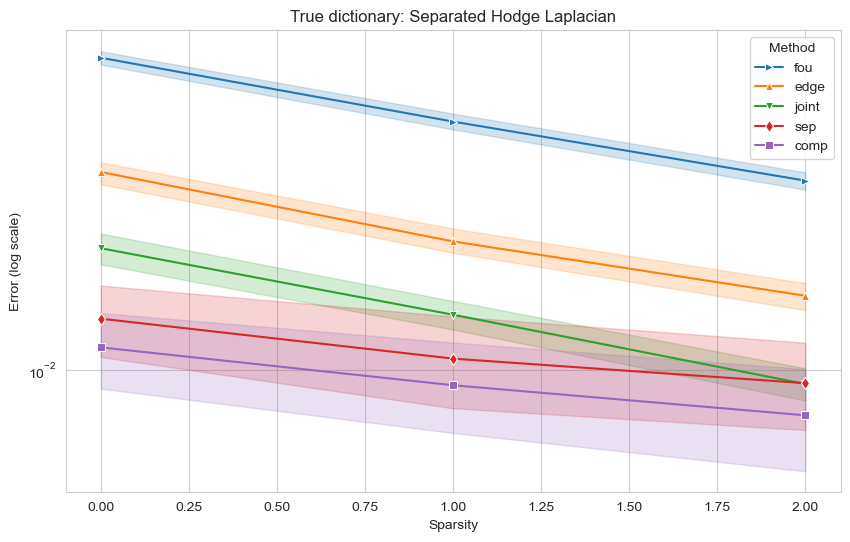

<Axes: title={'center': 'True dictionary: Separated Hodge Laplacian'}, xlabel='Sparsity', ylabel='Error (log scale)'>

In [ ]:
plot_error_curves(res,"sep")

In [ ]:
s=0
k0=0

init_params = {"J":J,
            "P":P,
            "c":c_true[s],
            "epsilon":epsilon_true[s],
            "true_prob_T":prob_T,
            "sub_size":100,
            "seed":0,
            "n":40,
            "K0":K0_coll[k0],
            "p_edges":0.162,
            "dictionary_type": dictionary_type,
            "G_true":G
            }

algo_params = {"lambda_":lambda_,
              "tol":tol,
              "patience":patience,
              "max_iter":max_iter,
              "QP":True,
              "mode":"optimistic"
              }

gt_model = TopoSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                **init_params)

gt_model.fit(Lu_true=Lu,
            init_mode="only_X",
            learn_topology=False,
            **algo_params,
            )

None


KeyError: 'G_true '

In [ ]:
s=0
k0=0

init_params = {"J":J,
            "P":P,
            "c":c_true[s],
            "epsilon":epsilon_true[s],
            "true_prob_T":prob_T,
            "sub_size":100,
            "seed":0,
            "n":40,
            "K0":K0_coll[k0],
            "p_edges":0.162,
            "dictionary_type": dictionary_type
            }

algo_params = {"lambda_":lambda_,
              "tol":tol,
              "patience":patience,
              "max_iter":max_iter,
              "QP":True,
              "mode":"optimistic",
              "warmup":1
              }

model = TopoSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                **init_params)

model.fit(Lu_true=Lu,
            init_mode="only_X",
            **algo_params,
            )

(0.07070383682846097, 0.07372531041279645, 0.0)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
import networkx as nx

def plot_learnt_topology(G_true, B2_true, model_gt, model_opt, model_pess=None, sub_size=100):

    try:
        topos = [model_gt, model_opt, model_pess]
        num_triangles = [G_true]
        incidence_mat = [B2_true, model_opt.B2, model_pess.B2]
        titles = [
            "True topology",
            "Inferred topology (optimistic method)",
            "Inferred topology (pessimistic method)",
        ]
        _, axs = plt.subplots(1, 3, figsize=(16, 6))
    except:
        incidence_mat = [B2_true, model_opt.B2]
        titles = ["True topology", "Inferred topology"]
        _, axs = plt.subplots(1, 2, figsize=(12, 6))

    i = 0

    for ax, title in zip(axs, titles):
        A = G_true.get_adjacency()
        tmp_G = nx.from_numpy_array(A)
        pos = nx.kamada_kawai_layout(tmp_G)
        nx.draw(tmp_G, pos, with_labels=False, node_color="purple", node_size=15, ax=ax)
        num_triangles = 0

        for triangle_index in range(B2_true.shape[1]):
            np.random.seed(triangle_index)
            color = np.random.rand(3)
            triangle_vertices = []

            for edge_index, edge in enumerate(tmp_G.edges):
                if edge_index < sub_size:
                    if incidence_mat[i][edge_index, triangle_index] != 0:
                        pos1 = tuple(pos[edge[0]])
                        pos2 = tuple(pos[edge[1]])
                        if pos1 not in triangle_vertices:
                            triangle_vertices.append(pos1)
                        if pos2 not in triangle_vertices:
                            triangle_vertices.append(pos2)
            if triangle_vertices != []:
                # num_triangles += 1
                triangle_patch = Polygon(
                    triangle_vertices,
                    closed=True,
                    facecolor=color,
                    edgecolor="black",
                    alpha=0.3,
                )
                ax.add_patch(triangle_patch)
        i += 1

        ax.set_title(title)
        ax.text(
            0.5,
            -0,
            r'' + f'Number of triangles: {num_triangles}  NMSE: {topos[i].min_error_test}',
            ha="center",
            transform=ax.transAxes,
        )
    plt.tight_layout()
    plt.show()

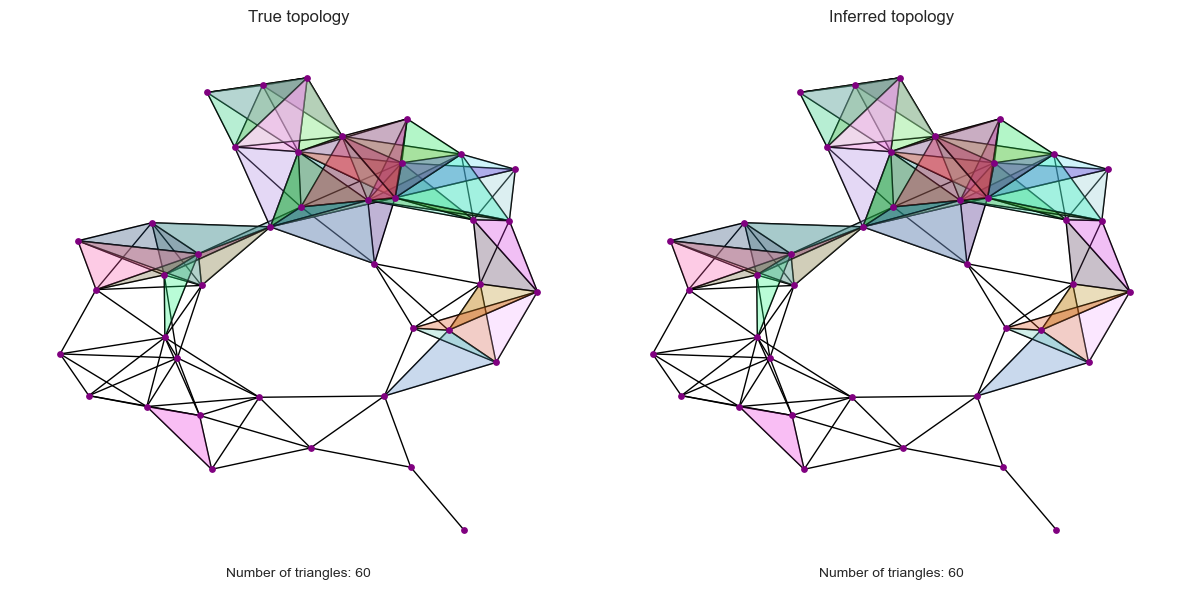

In [ ]:
plot_learnt_topology(G, B2_true, models["2,0"])

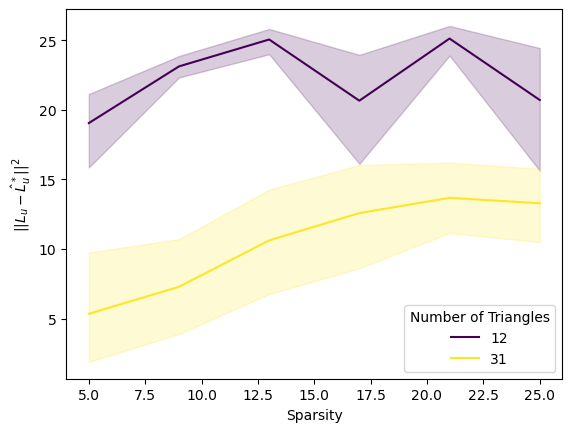

In [ ]:
# def process_pickle_results(directory):
#     """
#     Iterates over all pickle files in the specified directory and processes them.

#     Parameters:
#     directory (str): The path to the directory containing pickle files.
#     """
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import pickle
import re

res_df = pd.DataFrame()
PATH = os.path.join(os.getcwd(), "results\\final")
pattern = re.compile(r'(\d{2})\.(pkl|pickle)$')

if not os.path.exists(PATH):
    print(f"The directory {PATH} does not exist.")
else:
    for filename in os.listdir(PATH):
        # Check pickle files
        if filename.endswith(".pkl") or filename.endswith(".pickle"):

            file_path = os.path.join(PATH, filename)
            match = pattern.search(filename)
            if match:
                triangles = match.group(1)

            try:
                with open(file_path, 'rb') as f:
                    _ = pickle.load(f)
                    res = pickle.load(f)

                tmp_df = pd.DataFrame(res["complete"][2])
                tmp_df.columns = K0_coll
                tmp_df = tmp_df.melt(var_name="Sparsity", value_name="Error")
                tmp_df["Number of Triangles"] = nu - int(np.ceil(nu*(1-float(triangles)/100)))
                res_df = pd.concat([res_df, tmp_df])

            except Exception as e:
                print(f"Failed to process {filename}: {e}")

    final_plot = sns.lineplot(data=res_df,
                            x="Sparsity",
                            y="Error",
                            hue="Number of Triangles",
                            palette=sns.color_palette("viridis", as_cmap=True))
    
    final_plot.set(ylabel=r'$||L_u - \hat{L}_u^*||^2$')
    plt.show()
        

In [ ]:
min_error_fou_train = np.zeros((n_sim, len(K0_coll)))
min_error_fou_test = np.zeros((n_sim, len(K0_coll)))
min_error_sep_train = np.zeros((n_sim, len(K0_coll)))
min_error_sep_test = np.zeros((n_sim, len(K0_coll)))
min_error_edge_train = np.zeros((n_sim, len(K0_coll)))
min_error_edge_test = np.zeros((n_sim, len(K0_coll)))
min_error_joint_train = np.zeros((n_sim, len(K0_coll)))
min_error_joint_test = np.zeros((n_sim, len(K0_coll)))
approx_fou = np.zeros((n_sim, len(K0_coll)))
approx_sep = np.zeros((n_sim, len(K0_coll)))
approx_joint = np.zeros((n_sim, len(K0_coll)))
approx_edge = np.zeros((n_sim, len(K0_coll)))
approx_comp = np.zeros((n_sim, len(K0_coll)))

dict_errors = {
    "fourier": (min_error_fou_train, min_error_fou_test, approx_fou),
    "edge": (min_error_edge_train, min_error_edge_test, approx_edge),
    "joint": (min_error_joint_train, min_error_joint_test, approx_joint),
    "separated": (min_error_sep_train, min_error_sep_test, approx_sep),
}
k0_index=0
dict_types = {
    "fourier": ("Fourier", "fourier"),
    "edge": ("Edge Laplacian", "edge"),
    "joint": ("Hodge Laplacian", "joint"),
    "separated": ("Separated Hodge Laplacian", "separated"),
}

for sim in range(1,n_sim):
    for d in dict_types.items():
        try:
            (
                dict_errors[d[0]][0][sim, k0_index],
                dict_errors[d[0]][1][sim, k0_index],
                dict_errors[d[0]][2][sim, k0_index],
            ) = (
                dict_errors[d[0]][0][sim - 1, k0_index],
                dict_errors[d[0]][1][sim - 1, k0_index],
                dict_errors[d[0]][2][sim - 1, k0_index],
            )
        except:
            (
                dict_errors[d[0]][0][sim, k0_index],
                dict_errors[d[0]][1][sim, k0_index],
                dict_errors[d[0]][2][sim, k0_index],
            ) = (
                dict_errors[d[0]][0][sim + 1, k0_index],
                dict_errors[d[0]][1][sim + 1, k0_index],
                dict_errors[d[0]][2][sim + 1, k0_index],
            )


In [ ]:
dict_errors["edge"][2]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])